In [88]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import os
from PIL import Image
from io import BytesIO
import time

In [89]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [91]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [94]:
def souhaiel_model(tf,wgts='fightw.hdfs'):
    layers = tf.keras.layers
    models = tf.keras.models
    losses = tf.keras.losses
    optimizers = tf.keras.optimizers
    metrics = tf.keras.metrics
    num_classes = 2
    cnn = models.Sequential()
    #cnn.add(base_model)
    input_shapes=(160,160,3)
    np.random.seed(1234)
    vg19 = tf.keras.applications.vgg19.VGG19
    base_model = vg19(include_top=False,weights='imagenet',input_shape=(160, 160,3))
    # Freeze the layers except the last 4 layers (we will only use the base model to extract features)
    cnn = models.Sequential()
    cnn.add(base_model)
    cnn.add(layers.Flatten())
    model = models.Sequential()
    model.add(layers.TimeDistributed(cnn,  input_shape=(30, 160, 160, 3)))
    model.add(layers.LSTM(30 , return_sequences= True))
    model.add(layers.TimeDistributed(layers.Dense(90)))
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation="sigmoid"))
    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.load_weights(wgts)
    rms = optimizers.RMSprop()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
    return model


In [93]:
model1 = souhaiel_model(tf)
print(model1.summary())

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 30, 12800)         20024384  
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 30)            1539720   
_________________________________________________________________
time_distributed_33 (TimeDis (None, 30, 90)            2790      
_________________________________________________________________
dropout_32 (Dropout)         (None, 30, 90)            0         
_________________________________________________________________
global_average_pooling1d_16  (None, 90)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               46592     
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [96]:
from tensorflow.keras.utils import plot_model
model1= souhaiel_model(tf)
#plot_model(model1, to_file='souhaiel.png')

In [97]:
import numpy as np
from skimage.transform import resize
np.random.seed(1234)
model1 = souhaiel_model(tf)


In [98]:
graph = tf.compat.v1.get_default_graph

In [100]:
#graph

In [101]:
def video_reader(cv2,filename):
    frames = np.zeros((30, 160, 160, 3), dtype=np.float)
    i=0
    print(frames.shape)
    vc = cv2.VideoCapture(filename)
    if vc.isOpened():
        rval , frame = vc.read()
    else:
        rval = False
    frm = resize(frame,(160,160,3))
    frm = np.expand_dims(frm,axis=0)
    if(np.max(frm)>1):
        frm = frm/255.0
    frames[i][:] = frm
    i +=1
    print("reading video")
    while i < 30:
        rval, frame = vc.read()
        frm = resize(frame,(160,160,3))
        frm = np.expand_dims(frm,axis=0)
        if(np.max(frm)>1):
            frm = frm/255.0
        frames[i][:] = frm
        i +=1
    return frames

In [102]:
video_reader(cv2,'Blindinglights.mp4')

(30, 160, 160, 3)
reading video


array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [103]:
def pred_fight(model,video,acuracy=0.9):
    pred_test = model.predict(video)
    if pred_test[0][1] >=acuracy:
        return True , pred_test[0][1]
    else:
        return False , pred_test[0][1]

In [104]:
def main_fight(vidoss):
    vid = video_reader(cv2,vidoss)
    datav = np.zeros((1, 30, 160, 160, 3), dtype=np.float)
    datav[0][:][:] = vid
    millis = int(round(time.time() * 1000))
    print(millis)
    f , precent = pred_fight(model1,datav,acuracy=0.65)
    millis2 = int(round(time.time() * 1000))
    print(millis2)
    res_fight = {'violence':f ,'violenceestimation':str(precent)} 
    res_fight['processing_time'] =  str(millis2-millis)
    return res_fight

In [105]:
res = main_fight('Blindinglights.mp4')

(30, 160, 160, 3)
reading video
1624982752410
1624982762558


In [106]:
res

{'processing_time': '10148',
 'violence': False,
 'violenceestimation': '0.13656598'}

In [107]:
res = main_fight('fight.avi')

(30, 160, 160, 3)
reading video
1624982896955
1624982906470


In [108]:
res

{'processing_time': '9515', 'violence': True, 'violenceestimation': '0.86864'}

In [109]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import os
from flask import Flask , request , jsonify , Response
from PIL import Image
from io import BytesIO
import time
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend
from werkzeug.utils import secure_filename
from werkzeug.datastructures import  FileStorage
from collections import deque
import numpy as np
import argparse
import pickle
import cv2

In [110]:
model1 = souhaiel_model(tf)
print(model1.summary())

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 30, 12800)         20024384  
_________________________________________________________________
lstm_20 (LSTM)               (None, 30, 30)            1539720   
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 90)            2790      
_________________________________________________________________
dropout_40 (Dropout)         (None, 30, 90)            0         
_________________________________________________________________
global_average_pooling1d_20  (None, 90)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               46592     
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)             

[INFO] loading model and label binarizer...
Results =  [[0.08407789 0.9154513 ]]
Maximun Probability =  0.9154513
Difference of prob  0.8309025764465332


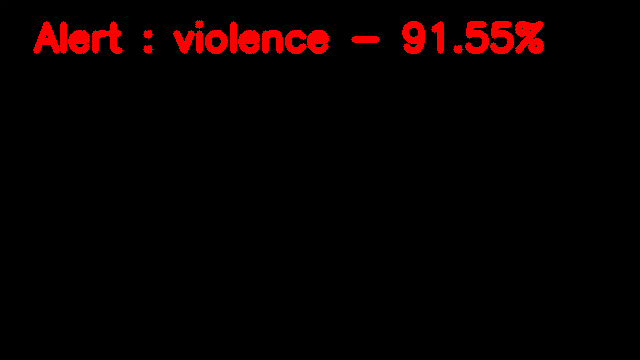

Results =  [[0.08407789 0.9154513 ]]
Maximun Probability =  0.9154513
Difference of prob  0.8309025764465332


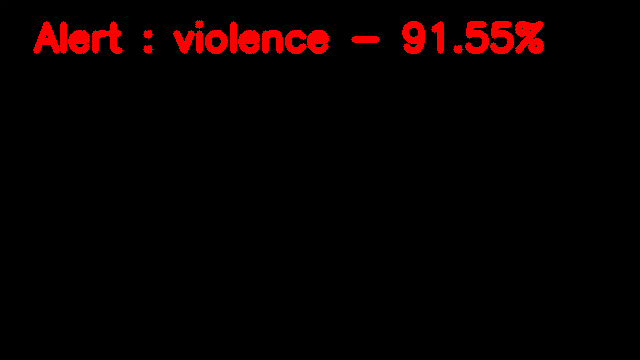

Results =  [[0.08407789 0.9154513 ]]
Maximun Probability =  0.9154513
Difference of prob  0.8309025764465332


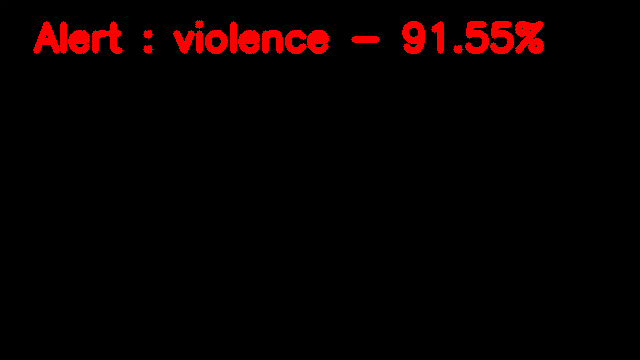

Results =  [[0.08407789 0.9154513 ]]
Maximun Probability =  0.9154513
Difference of prob  0.8309025764465332


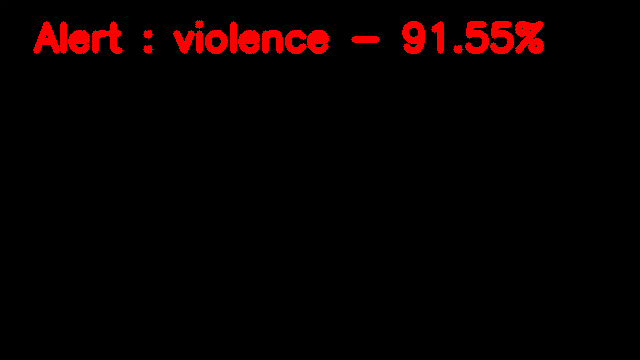

Results =  [[0.08407789 0.9154512 ]]
Maximun Probability =  0.9154512
Difference of prob  0.8309024572372437


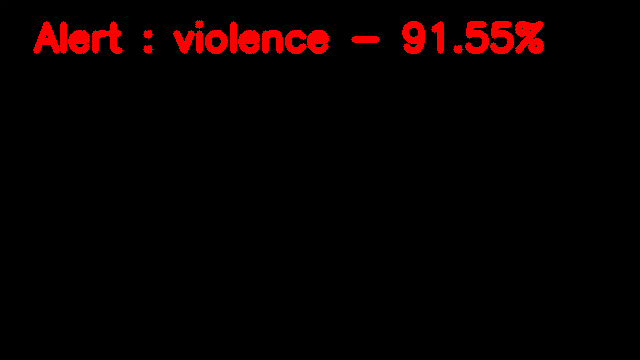

Results =  [[0.08407789 0.9154512 ]]
Maximun Probability =  0.9154512
Difference of prob  0.8309024572372437


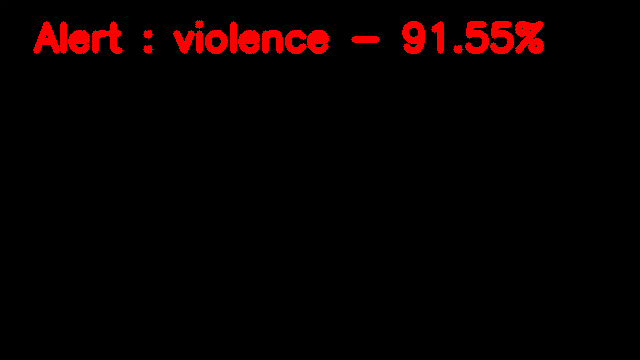

Results =  [[0.08407789 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


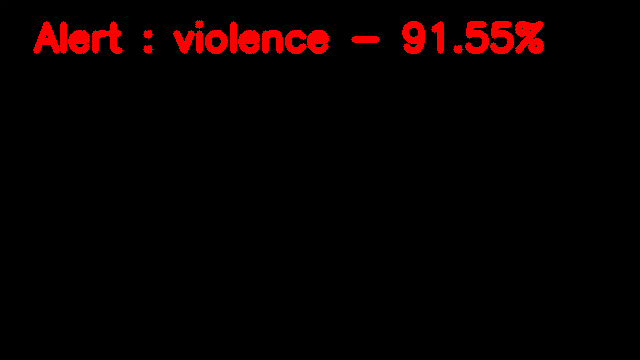

Results =  [[0.08407789 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


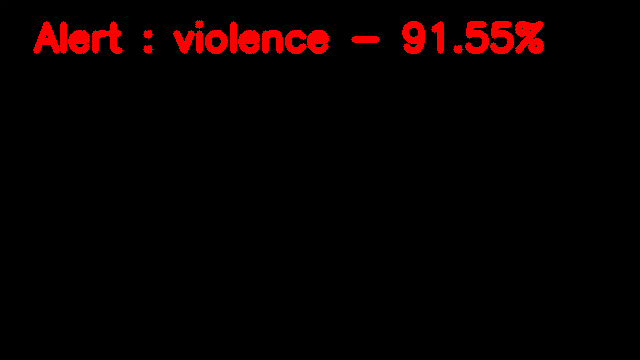

Results =  [[0.08407789 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


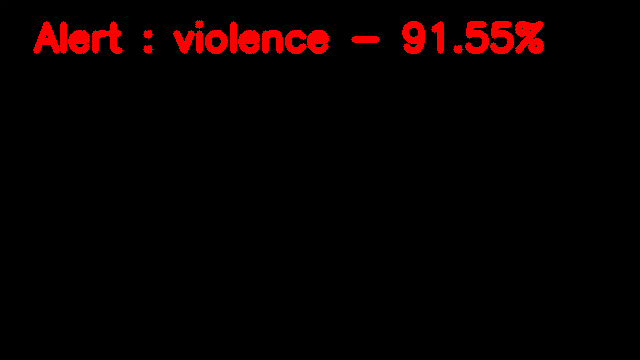

Results =  [[0.08407789 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


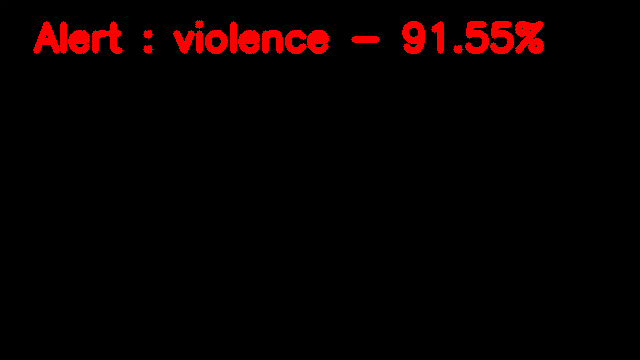

Results =  [[0.08407789 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


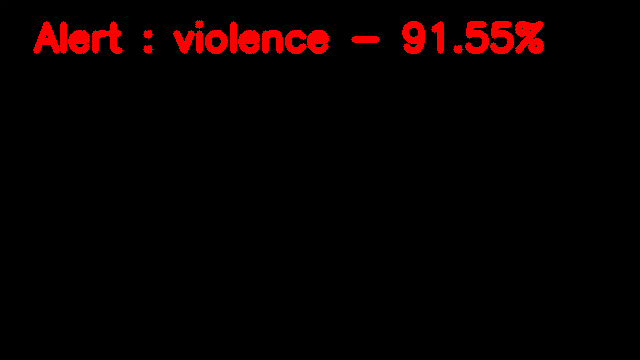

Results =  [[0.08407789 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


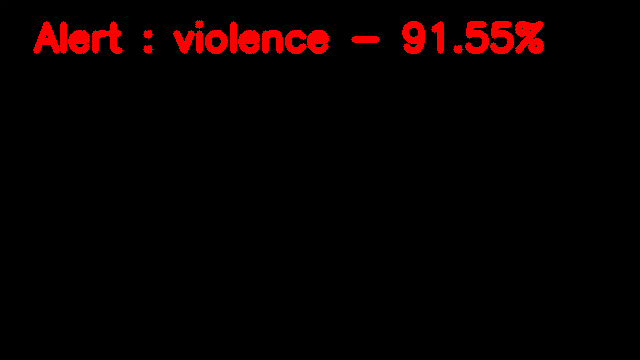

Results =  [[0.08407789 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


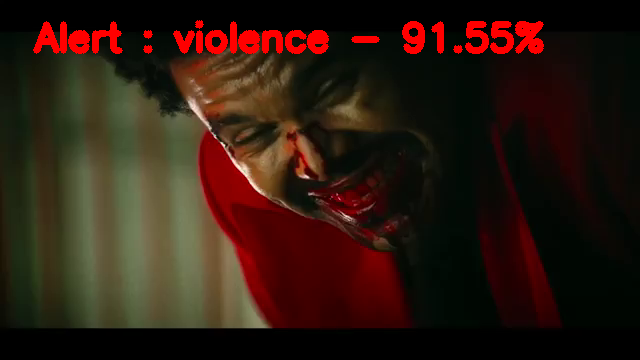

Results =  [[0.08407789 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


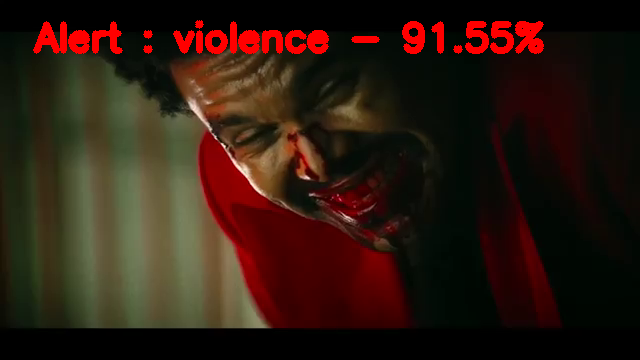

Results =  [[0.08407788 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


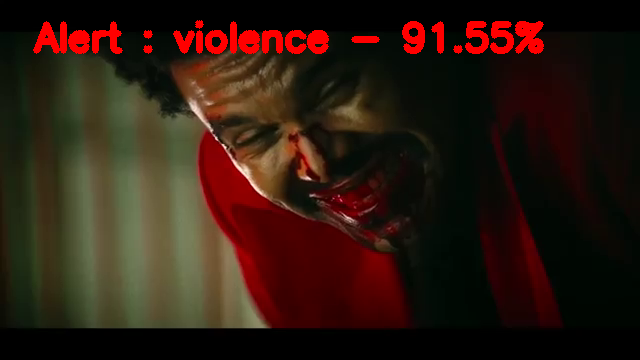

Results =  [[0.08407788 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


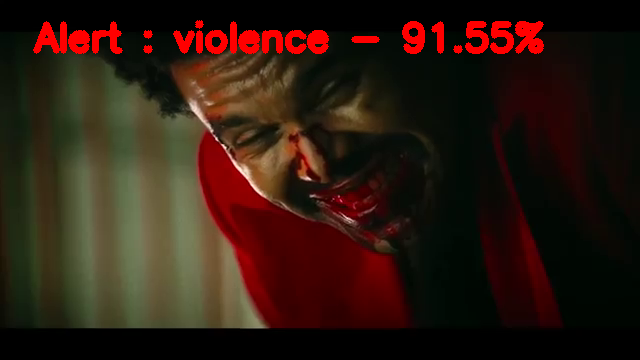

Results =  [[0.08407788 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


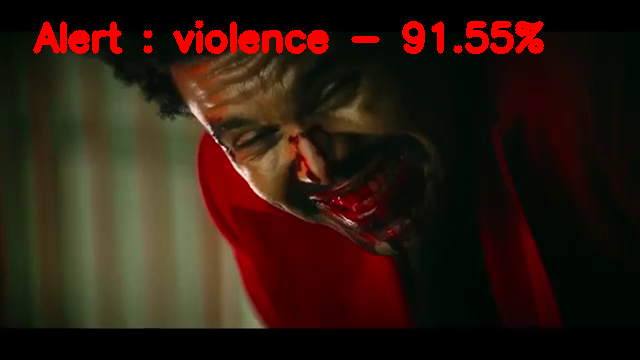

Results =  [[0.08407787 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


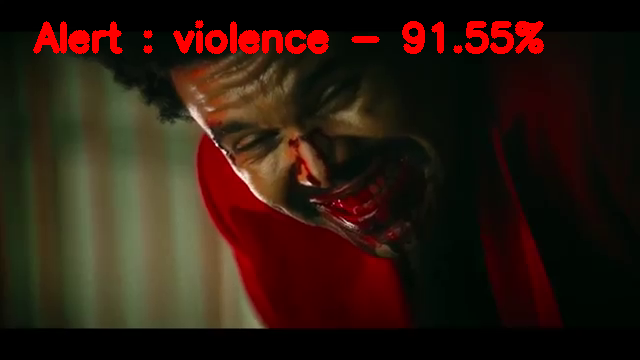

Results =  [[0.08407787 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


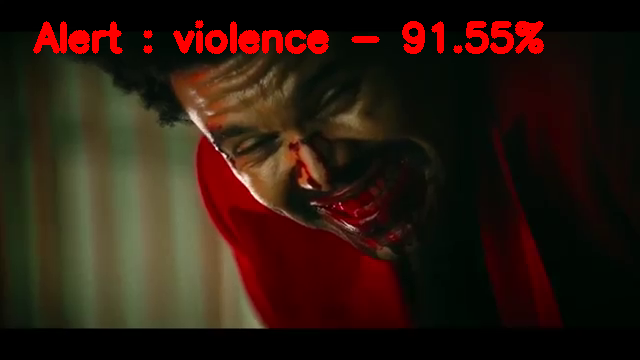

Results =  [[0.08407787 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


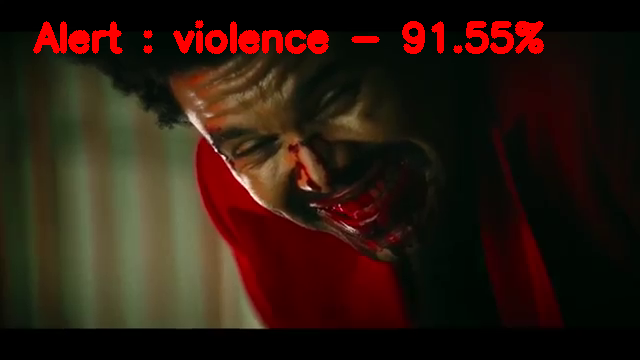

Results =  [[0.08407787 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


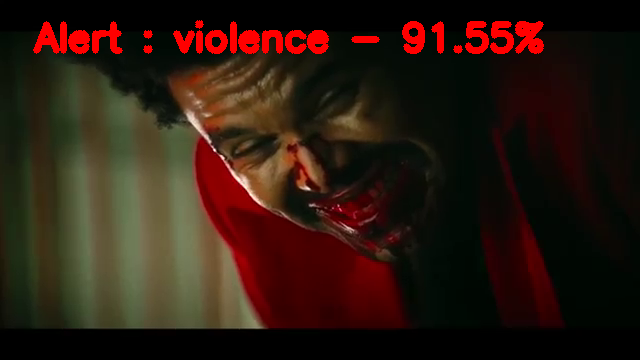

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


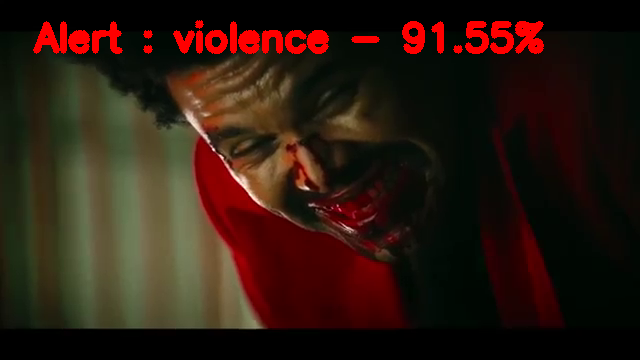

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


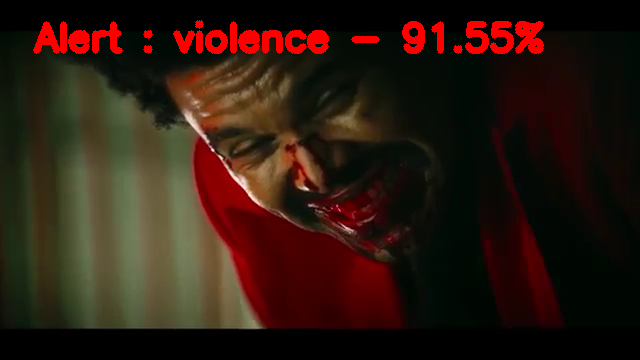

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


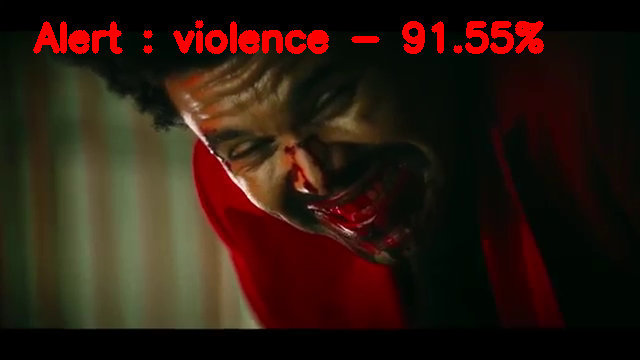

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


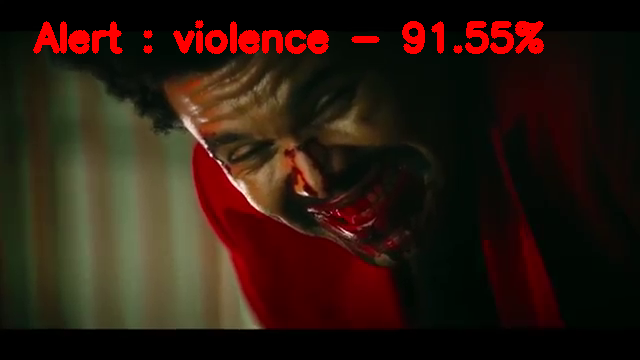

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


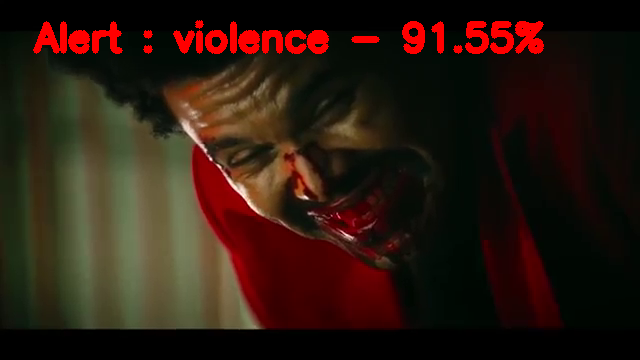

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


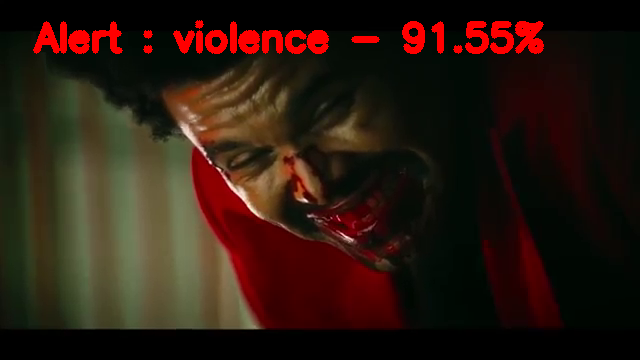

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


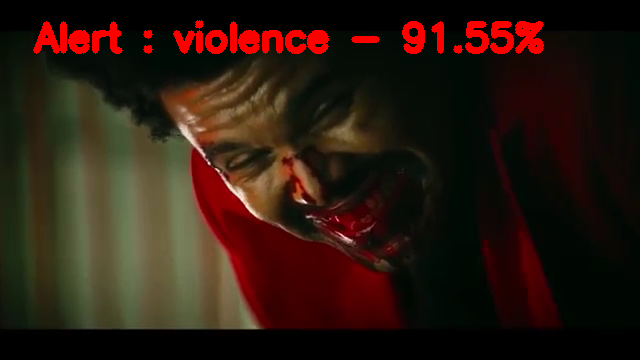

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


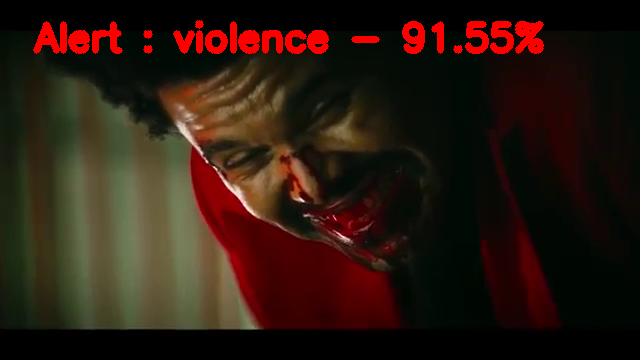

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


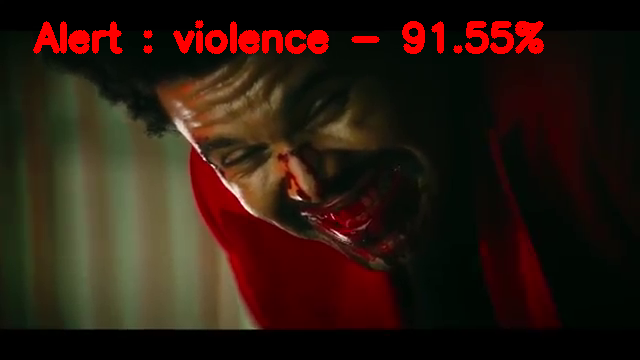

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


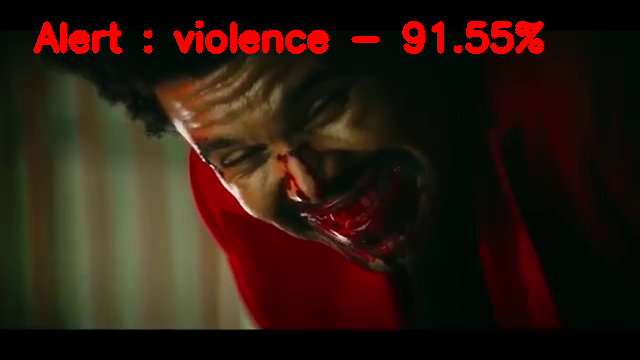

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


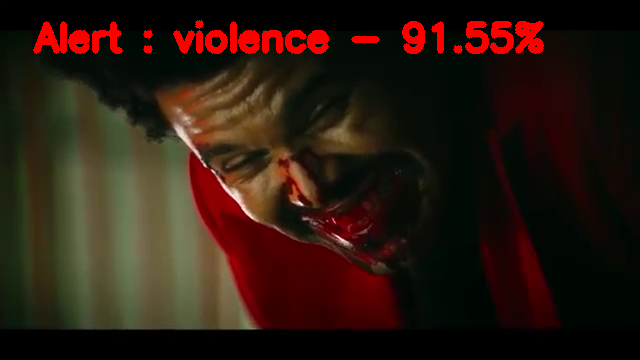

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


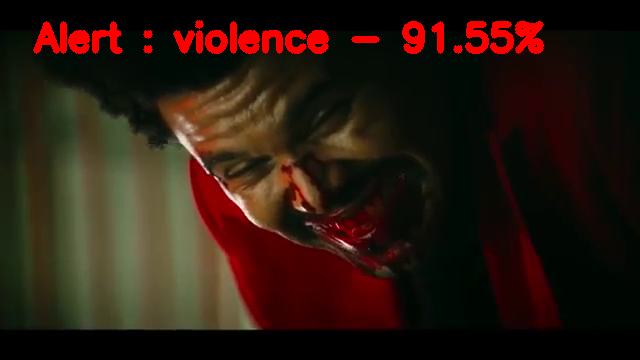

Results =  [[0.08407786 0.9154511 ]]
Maximun Probability =  0.9154511
Difference of prob  0.8309022188186646


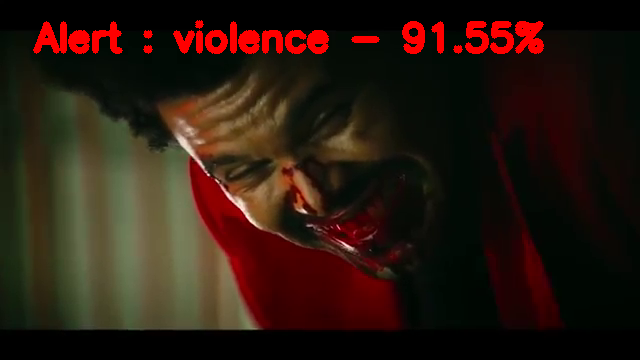

Results =  [[0.08407786 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


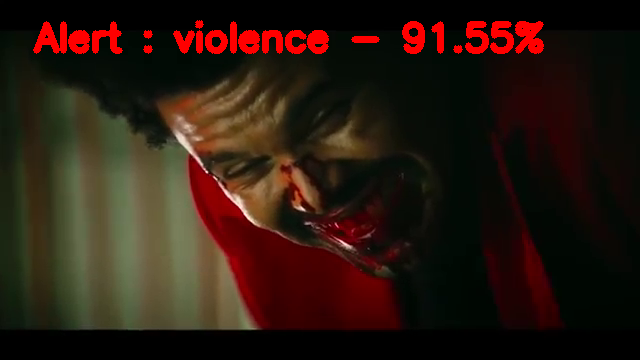

Results =  [[0.08407786 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


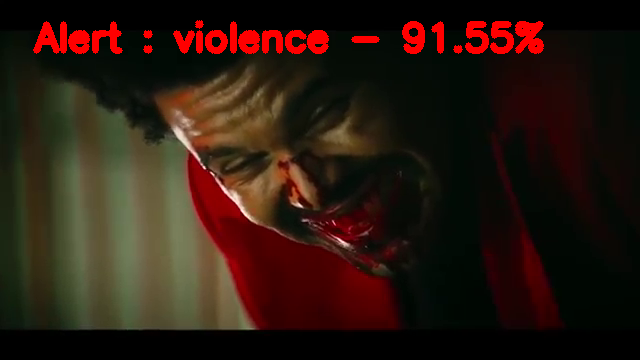

Results =  [[0.08407786 0.91545117]]
Maximun Probability =  0.91545117
Difference of prob  0.8309023380279541


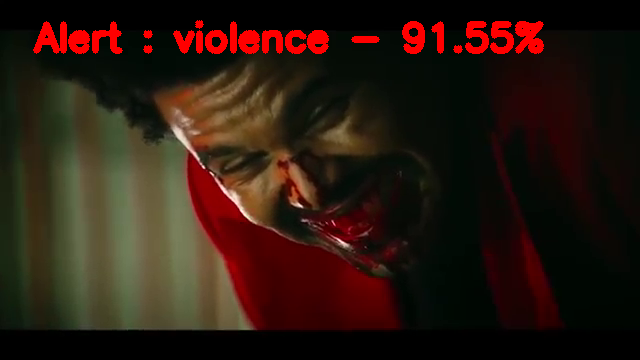

KeyboardInterrupt: ignored

In [127]:
 from google.colab.patches import cv2_imshow

args = {
  "input": "fight.avi",
  "size": 128,
  "output": "prova.mp4"
}

model1 = souhaiel_model(tf)
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--input", required=True,	help="path to our input video")
#ap.add_argument("-o", "--output", required=True,	help="path to our output video")
#ap.add_argument("-s", "--size", type=int, default=128,	help="size of queue for averaging")
#args = vars(ap.parse_args())

# load the trained model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = model1
# initialize the image mean for mean subtraction along with the
# predictions queue
#mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=args["size"])

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
vc=cv2.VideoCapture('Blindinglights.mp4')
fps = vs.get(cv2.CAP_PROP_FPS)
writer = None
(W, H) = (None, None)
#client = Client("ACea4cecca40ebb1bf4594098d5cef4541", "32789639585561088d5937514694e115") #update from twilio
prelabel = ''
ok = 'Normal'
okk='violence'
i=0
frames = np.zeros((30, 160, 160, 3), dtype=np.float)
datav = np.zeros((1, 30, 160, 160, 3), dtype=np.float)
frame_counter=0

# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frm) = vc.read()
    
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frm.shape[:2]
    #framecount = framecount+1
    # clone the output frame, then convert it from BGR to RGB
    # ordering, resize the frame to a fixed 224x224, and then
    # perform mean subtraction
    output = frm.copy()
    while i < 30:
        rval, frame = vs.read()
        frame_counter +=1
        if frame_counter == vs.get(cv2.CAP_PROP_FRAME_COUNT):
            frame_counter = 0 #Or whatever as long as it is the same as next line
            vs.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame = resize(frame,(160,160,3))
        frame = np.expand_dims(frame,axis=0)
        if(np.max(frame)>1):
            frame = frame/255.0
        frames[i][:] = frame
        i +=1
        
    datav[0][:][:] =frames
    frames -= mean
    

	# make predictions on the frame and then update the predictions
	# queue
    #preds = model1.predict(datav)
#	print('Preds = :', preds)
	
#	total = (preds[0]+ preds[1]+preds[2] + preds[3]+ preds[4]+preds[5])
#	maximum = max(preds)
#	rest = total - maximum
    
#	diff = (.8*maximum) - (.1*rest)
#	print('Difference of prob ', diff)
#	th = 100
#	if diff > .60:
#		th = diff
#	print('Old threshold = ', th)
    
    
    prediction = preds.argmax(axis=0)
    Q.append(preds)

	# perform prediction averaging over the current history of
	# previous predictions
    results = np.array(Q).mean(axis=0)
    print('Results = ', results)
    maxprob = np.max(results)
    print('Maximun Probability = ', maxprob)
    i = np.argmax(results)
    rest = 1 - maxprob
    
    diff = (maxprob) - (rest)
    print('Difference of prob ', diff)
    th = 100
    if diff > .80:
        th = diff
      
        
        
        
    if (preds[0][1]) < th:
        text = "Alert : {} - {:.2f}%".format((ok), 100 - (maxprob * 100))
        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)
    else:
		
        text = "Alert : {} - {:.2f}%".format((okk), maxprob * 100)
        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 0, 255), 5) 
#		if label != prelabel:
#			client.messages.create(to="<+country code>< receiver mobile number>", #for example +918255555555
#                       from_="+180840084XX", #sender number can be coped from twilo
#                       body='\n'+ str(text) +'\n Satellite: ' + str(camid) + '\n Orbit: ' + location)
    


	# check if the video writer is None
    if writer is None:
	    # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(args["output"], fourcc, 27.0,
			(W, H), True)

	# write the output frame to disk
    writer.write(output)

	# show the output image
    cv2_imshow(output)
    key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
#print('Frame count', framecount)
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()
vc.release()